# Binary Classification of 747 vs A380
The goal is to classify a picture between two classes : an Boeing 747 or an Airbus A380

There is a nice script to get images from Google : https://github.com/boxabirds/fastai-helpers/blob/master/training-data-generator.py, it's based on https://github.com/hardikvasa/google-images-download wich use ChromeDriver to automate the process.

In [1]:
# XXX Testter resnet110 ?

# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
PATH = "../../datasets/boeing_vs_airbus/"
!rm -r {PATH}tmp
## Getting dataset
#!mkdir {PATH}
#!pip install google_images_download
#!ls ../../datasets/
#!cd {PATH} && mkdir -p train/747 train/A380 test/747 test/A380  valid/747 valid/A380
#!cd {PATH}/747 && googleimagesdownload --keywords "Boing 747" --limit 1000 --chromedriver /usr/local/bin/chromedriver
#!cd {PATH}/A380 && googleimagesdownload --keywords "Airbus A380" --limit 1000 --chromedriver /usr/local/bin/chromedriver
## Getting models weights
#!cd ./fastai && wget http://files.fast.ai/models/weights.tgz && tar -xvzf weights.tgz
#!ls {PATH}

In [3]:
print("Setting CUDA devices...")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="6"
print("Loading Fast.AI modules...")
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.metrics import confusion_matrix

sz=299
arch=resnext50
#arch=resnet34
bs=132

def plot_ep_vals(ep_vals):
    plt.ylabel("loss")
    plt.xlabel("epoch")
    epochs = len(ep_vals)#ep_vals.keys()
    #plt.xticks(np.asarray(list(epochs)))
    plt.xticks((list(ep_vals)))
    #print((list(ep_vals)))
    trn_losses = [item[0] for item in list(ep_vals.values())]
    #print(trn_losses)
    val_losses = [item[1] for item in list(ep_vals.values())]
    #print(val_losses)
    plt.plot(list(ep_vals), trn_losses, c='b', label='train')
    plt.plot(list(ep_vals), val_losses, c='r', label='validation')
    plt.legend(loc='upper left')

def plot_the_confusion_matrix():
    log_preds,y = learn.TTA()
    probs = np.mean(np.exp(log_preds),0)
    accuracy_np(probs, y)
    preds = np.argmax(probs, axis=1)
    probs = probs[:,1]
    cm = confusion_matrix(y, preds)
    plot_confusion_matrix(cm, data.classes)
    # precission = VP / (VP + FP)
    precision = cm[0][0]/(cm[0][1]+cm[0][0]);
    print("Precision : ", precision)
    # recall =  = VP / (VP + FN)
    recall = cm[0][0]/(cm[1][0]+cm[0][0]);
    print("Recall : ", recall)
    F1 = 2 * ((precision*recall)/(precision + recall))
    print("F1 : ", F1)
    F2 = 5 * ((precision*recall)/(4*precision + recall))
    print("F2 : ", F2)
    return cm

Setting CUDA devices...
Loading Fast.AI modules...


/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
print("CuDNN optimization is ", torch.backends.cudnn.enabled)

CuDNN optimization is  True


# Training from sratch
We begin with an empty ResNext50 model.
First we compute the mean and standard deviation of all images to center them.
## Computing mean and stddev

In [5]:

import glob
import PIL
means = np.array([0.0,0.0,0.0])
files = [val for sublist in [[os.path.join(i[0], j) for j in i[2]] for i in os.walk(f'{PATH}train')] for val in sublist]
print("Input images number : ", len(files))
deviations = np.array([0.0,0.0,0.0])
#variances = np.array([0,0,0])
variance = np.array([0.0,0.0,0.0])
for image in files:
    #print(image)
    img_stats = PIL.ImageStat.Stat(PIL.Image.open(image), mask=None)
    means += np.array(img_stats.mean)
    variance += np.array(img_stats.var)

stddev = np.sqrt(variance) / len(files)
print("stddev with PIL : ", stddev)

mean = np.array(means) / len(files) / 255
print("Means with PIL : ", mean)
stats = (mean, stddev)

Input images number :  1310


/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


stddev with PIL :  [1.54975 1.51391 1.60444]
Means with PIL :  [0.53286 0.5643  0.59667]


### Prepare data an model

In [6]:
image_size=128
#stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))
tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=4, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=False)

In [7]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 299, 299]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 75, 75]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 75, 

The model is realy deep as it make use of 168 layers.

How much input data do we get ?

(array([666.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 644.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

(array([155.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 155.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

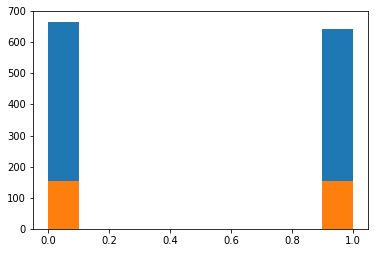

In [8]:
# This is the label for a val data
plt.hist(data.trn_y)
plt.hist(data.val_y)

/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


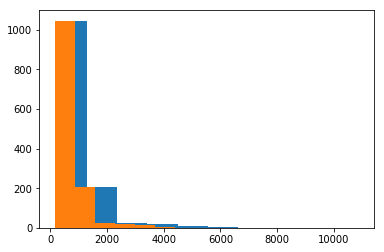

In [9]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)
plt.hist(row_sz);
plt.hist(col_sz);

(array([ 23.,  51.,  49.,  74., 119., 179.,  77., 100.,  33.,  59.]),
 array([220. , 297.2, 374.4, 451.6, 528.8, 606. , 683.2, 760.4, 837.6, 914.8, 992. ]),
 <a list of 10 Patch objects>)

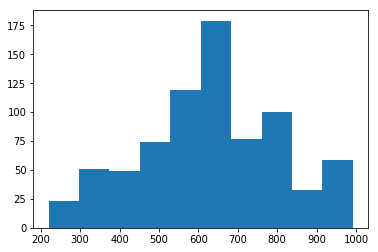

In [10]:
plt.hist(row_sz[row_sz < 1000])

We have few data

### Guess learning rate

 91%|█████████▏| 300/328 [00:17<00:01, 17.20it/s, loss=3.22] 

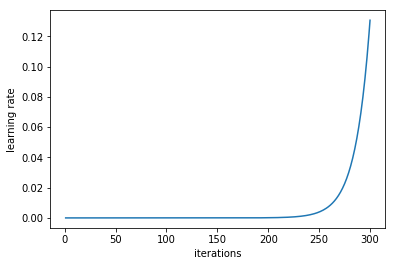

In [11]:
lrf=learn.lr_find(1e-10, end_lr=1)
learn.sched.plot_lr()

In [12]:
#?learn.lr_find

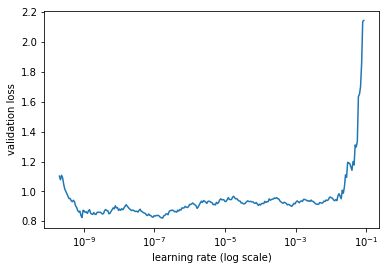

In [13]:
learn.sched.plot()

epoch      trn_loss   val_loss   accuracy                    
    0      0.81142    0.716812   0.458065  
    1      0.770269   0.704634   0.480645                    
    2      0.741789   0.704154   0.487097                    
    3      0.770416   0.694293   0.512903                    
    4      0.735326   0.696878   0.535484                    
    5      0.74027    0.693342   0.529032                    
    6      0.712799   0.694741   0.525806                    
    7      0.724256   0.692792   0.516129                    
    8      0.717919   0.697548   0.522581                    
    9      0.695779   0.692008   0.490323                    
    10     0.716288   0.695996   0.503226                    
    11     0.689096   0.691746   0.535484                    
    12     0.703584   0.699532   0.512903                    
    13     0.683006   0.69595    0.5                         
    14     0.731501   0.692815   0.516129                    
    15     0.704786   0.68

array([[150,   5],
       [148,   7]])

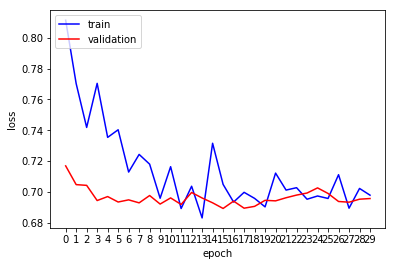

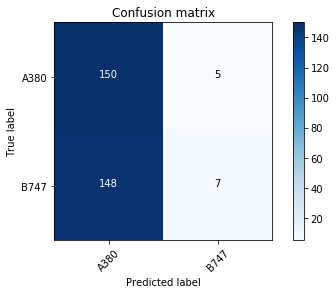

In [14]:
#F2 :  0.58 for lr=1e-2, image_size=128, batch_size=150, epoch=30 # val_loss begin at 4.4 and acc stay at 0.50 
#F2 :  0.02 for lr=1e-3, image_size=128, batch_size=256, epoch=30 # very erratic graph
#F2 :  0.55 for lr=1e-4, image_size=128, batch_size=256, epoch=30
#F2 :  0.11 for lr=1e-5, image_size=128, batch_size=256, epoch=30
#F2 :  0.55 for lr=1e-4, image_size=128, batch_size=128, epoch=30
#F2 :  0.49 (56.12 %) for lr=1e-4, image_size=128, batch_size=64
#F2 :  0.55 (49.35 %) for lr=1e-4, image_size=128, batch_size=64

lr=1e-4
image_size=128
batch_size=64
epoch=30
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, image_size), bs=batch_size, num_workers=num_cpus())
vals_s2s, global_results = learn.fit(lr, n_cycle=epoch, get_ep_vals=True)
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=False)
print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
plot_ep_vals(global_results)
plot_the_confusion_matrix()

In [15]:
#learn.sched.plot_loss()

The model had learn quite nothing. But it is not surprising with so small dataset.

## Fine tuning

epoch      trn_loss   val_loss   accuracy                  
    0      0.940396   0.736323   0.503226  
    1      0.909574   0.712123   0.535484                  
    2      0.879867   0.682585   0.603226                  
    3      0.832794   0.663889   0.603226                  
    4      0.80113    0.665556   0.609677                  
    5      0.76231    0.644285   0.606452                  
    6      0.72663    0.635287   0.635484                  
    7      0.693773   0.611124   0.648387                  
    8      0.662675   0.605802   0.677419                  
    9      0.62487    0.591073   0.696774                  
    10     0.591573   0.585735   0.670968                  
    11     0.565049   0.575241   0.7                       
    12     0.537133   0.541591   0.716129                  
    13     0.505539   0.53065    0.709677                  
    14     0.479101   0.529353   0.716129                  
    15     0.453898   0.523068   0.729032               

array([[131,  24],
       [ 45, 110]])

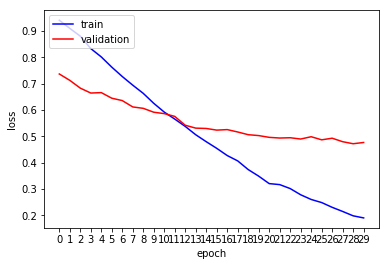

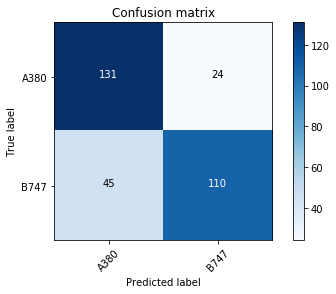

In [16]:
!rm -r {PATH}tmp

#F2 :  0.83 for image_size=128, batch_size=128, lr=1e-2
# F2 :  0.80 for image_size=128, batch_size=150, lr=1e-3
# F2 :  0.76 for image_size=128, batch_size=150, lr=1e-4 # good graph
# F2 :  0.83 for image_size=128, batch_size=150, lr=1e-2 # val loss goes up => overfitting
# F2 :  0.81 (acc 81.61 %) for image_size=128, batch_size=150, lr=1e-3 # val_loss go down, then slowly up
# F2 :  0.76 (acc 76.45 %) for image_size=128, batch_size=64, lr=1e-4 # good graph, val_loss slowly go down
# F2 :  0.76 (acc 77.74 %) for image_size=128, batch_size=64, lr=1e-4 # good graph, val_loss slowly go down

image_size=128
batch_size=64
lr=1e-4
epoch=30
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, image_size), bs=batch_size, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=True)
learn.unfreeze()
vals_s2s, global_results = learn.fit(lr, n_cycle=epoch, get_ep_vals=True)
print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
plot_ep_vals(global_results)
plot_the_confusion_matrix()

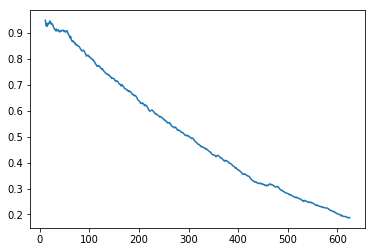

In [17]:
learn.sched.plot_loss()

## Data augmentation
Apply random operations on pictures to help the model to generalize.
Data augmentation options : https://becominghuman.ai/data-augmentation-using-fastai-aefa88ca03f1

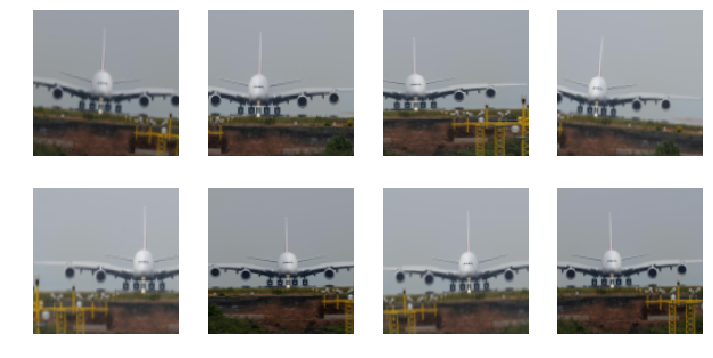

In [18]:
aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),
        RandomFlip(),
        RandomLighting(0.05, 0.05,tfm_y=TfmType.NO),
        RandomZoom(zoom_max=0.2),
        RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, image_size, aug_tfms=aug_tfms, max_zoom=1.1)


def get_augs():
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=2, num_workers=2)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

ims = np.stack([get_augs() for i in range(8)])
plots(ims, rows=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.875801   0.668111   0.583871  
    1      0.794349   0.636772   0.667742                  
    2      0.696641   0.577963   0.712903                  
    3      0.602789   0.542088   0.735484                  
    4      0.525667   0.503054   0.751613                  
    5      0.456461   0.458946   0.777419                  
    6      0.378023   0.462388   0.796774                  
    7      0.316814   0.44646    0.8                       
    8      0.267342   0.448572   0.793548                  
    9      0.218364   0.434825   0.829032                  
    10     0.17909    0.430264   0.841935                  
    11     0.148228   0.424262   0.851613                  
    12     0.132105   0.418754   0.845161                  
    13     0.116361   0.432731   0.841935                  
    14     0.100902   0.448418   0.822581                  
    15     0.089182   0.445924   0.83871                

array([[134,  21],
       [ 26, 129]])

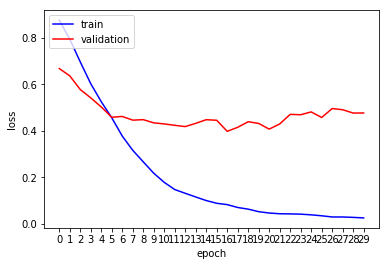

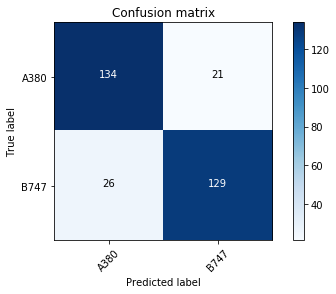

In [19]:
!rm -r {PATH}tmp
# F2 :  0.77 for image_size=128, batch_size=64, lr=1e-2 # val_loss don't go down
# F2 :  0.83 for image_size=128, batch_size=128, lr=1e-3, epoch=30
# F2 :  0.75 for image_size=128, batch_size=256, lr=1e-4, epoch=30
# F2 :  0.81 for image_size=128, batch_size=64, lr=1e-4 # good graph
# F2 :  0.85 (acc 84.19 %) for image_size=128, batch_size=64, lr=1e-3 # val_loss go slowy up
# F2 :  0.79 (acc 76.45 %) for image_size=128, batch_size=64, lr=1e-4 # val_loss still go down
# F2 :  0.84 (acc 85.16 %) for image_size=128, batch_size=64, lr=1e-3 # val_loss go slowy up

image_size=128
batch_size=64
lr=1e-3
epoch=30

data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=batch_size, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=True)
learn.unfreeze()
vals_s2s, global_results = learn.fit(lr, n_cycle=epoch, get_ep_vals=True)
print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
plot_ep_vals(global_results)
plot_the_confusion_matrix()

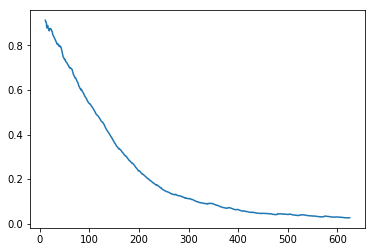

In [20]:
learn.sched.plot_loss()

## Multiple size

epoch      trn_loss   val_loss   accuracy                  
    0      0.826303   0.658777   0.632258  
After  1  epochs, the accuracy is  63.22 %
Saving to  resnext50_1_300_acc63.22_weights


epoch      trn_loss   val_loss   accuracy                  
    0      0.608011   0.580932   0.722581  
    1      0.528939   0.512591   0.780645                  
    2      0.451219   0.470156   0.796774                  
    3      0.377719   0.47158    0.803226                  
    4      0.302023   0.501059   0.809677                  
    5      0.23687    0.529229   0.825806                  
    6      0.190538   0.507528   0.825806                  
    7      0.167167   0.500315   0.835484                  
    8      0.145812   0.485508   0.851613                  
    9      0.121817   0.487984   0.848387                  
After  11  epochs, the accuracy is  84.83 %
Saving to  resnext50_11_64_acc84.83_weights


epoch      trn_loss   val_loss   accuracy                   
    0      0.07246    0.499115   0.854839  
    1      0.062525   0.594346   0.825806                   
    2      0.058458   0.639939   0.812903                   
    3      0.054743   0.653762   0.835484                   
    4      0.05046    0.592165   0.851613                   
    5      0.061491   0.600586   0.848387                   
    6      0.052421   0.580322   0.854839                   
    7      0.049712   0.654689   0.841935                   
    8      0.044124   0.618218   0.848387                   
    9      0.042881   0.596045   0.848387                   
After  21  epochs, the accuracy is  84.83 %
Saving to  resnext50_21_128_acc84.83_weights


epoch      trn_loss   val_loss   accuracy                   
    0      0.030361   0.590531   0.851613  
    1      0.031827   0.632764   0.848387                   
    2      0.026383   0.633489   0.848387                   
    3      0.025812   0.65647    0.841935                   
    4      0.023797   0.670822   0.83871                    
    5      0.023938   0.686105   0.829032                   
    6      0.020868   0.669445   0.835484                   
    7      0.021358   0.705393   0.832258                   
    8      0.020151   0.689231   0.825806                   
After  30  epochs, the accuracy is  82.58 %
Saving to  resnext50_30_300_acc82.58_weights
[[135  20]                                   
 [ 25 130]]
Precision :  0.8709677419354839
Recall :  0.84375
F1 :  0.8571428571428571
F2 :  0.8490566037735848


array([[135,  20],
       [ 25, 130]])

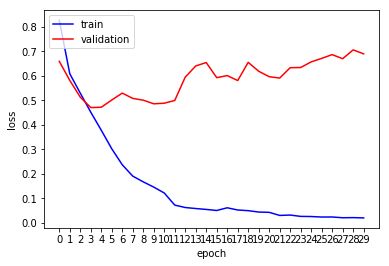

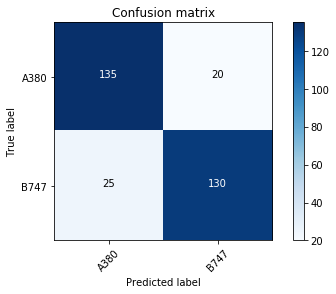

In [48]:
!rm -r {PATH}tmp
#F2 :  0.82 for learning_rate = 1e-2, dropout = [0.25,0.5], image_size = 128, batch_size = 150 # val_loss goes up
#F2 :  0.83 for learning_rate = 1e-2, dropout = 0.5, image_size = 128, batch_size = 150
#F2 :  0.61 for learning_rate = 1e-4, dropout = 0.5, image_size = 128, batch_size = 150 # bad graph
#F2 :  0.78 (acc 76.45 %) for learning_rate = 1e-3, dropout = [0.25,0.5], image_size = 128, batch_size = 150 # good graph
#F2 :  0.81 (acc 82.25 %) for learning_rate = 1e-3, dropout = [0.25,0.5], image_size = 128, batch_size = 64 # good, val_loss goes down
#F2 :  0.84 (acc 82.58 %) for learning_rate = 1e-2, dropout = [0.25,0.5], image_size = 128, batch_size = 64 # better acc but val_loss goes up


learning_rate = 1e-3
dropout = 0.5 #[0.25,0.5]
image_size = 128
batch_size = 64

global_results = collections.OrderedDict([])
aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO), RandomFlip(), RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2),RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, image_size, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=batch_size, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=dropout, pretrained=True)
learn.unfreeze()
training_loop = [
    [123, 300, 1],
    [512, 64, 10],
    [150, 128, 10],
    [123, 300, 10],
]

for bs, sz, epoch in training_loop:
    lr=np.array([learning_rate/100,learning_rate/10,learning_rate]) # Learning rate plus faible pour les premières couche, pour ré-apprendre un peu si necessaire
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    vals_s2s, ep_vals_s2s = learn.fit(lr, n_cycle=epoch, get_ep_vals=True)
    if len(global_results) > 0:
        #print(global_results)
        for k, v in ep_vals_s2s.items():
            global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    fichier = arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + "_acc" + str(vals_s2s[1]*100)[:5] + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)
plot_ep_vals(global_results)
plot_the_confusion_matrix()

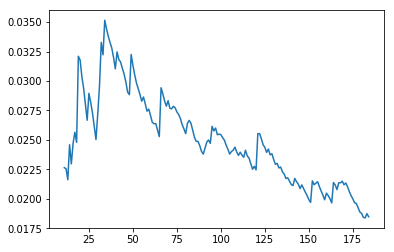

In [49]:
learn.sched.plot_loss()

## SGDR - Learning rate anealing

SGDR : Earlier we said 3 is the number of epochs, but it is actually *cycles*. So if cycle_len=2 , it will do 3 cycles where each cycle is 2 epochs (i.e. 6 epochs). Then why did it 7? It is because of cycle_mult :
    cycle_mult=2 : this multiplies the length of the cycle after each cycle (1 epoch + 2 epochs + 4 epochs = 7 epochs).

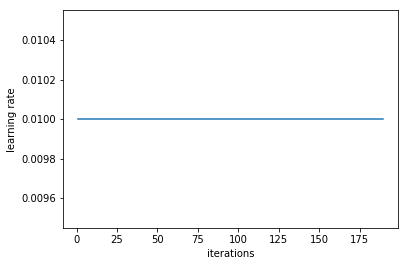

In [50]:
learn.sched.plot_lr()

Hyperparameters : Batch size= 123  Drop out= 0.5  Learning rate= 0.001  Cycle= 1  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                    
    0      0.727433   0.535202   0.741935  
After  1  epochs, the accuracy is  74.19 %
Saving to  resnext50_1_300_acc74.19_weights
Hyperparameters : Batch size= 512  Drop out= 0.5  Learning rate= 0.001  Cycle= 10  Images sizes= 64


epoch      trn_loss   val_loss   accuracy                    
    0      0.561361   0.460237   0.787097  
    1      0.40265    0.369899   0.825806                    
    2      0.38444    0.327701   0.851613                    
    3      0.317302   0.286455   0.890323                    
    4      0.303763   0.257851   0.896774                    
    5      0.269498   0.274147   0.877419                    
    6      0.246187   0.224844   0.909677                    
    7      0.23555    0.188529   0.919355                    
    8      0.220756   0.205263   0.909677                    
    9      0.186233   0.222158   0.903226                    
After  11  epochs, the accuracy is  90.32 %
Saving to  resnext50_11_64_acc90.32_weights
Hyperparameters : Batch size= 150  Drop out= 0.5  Learning rate= 0.001  Cycle= 10  Images sizes= 128


epoch      trn_loss   val_loss   accuracy                    
    0      0.208253   0.173753   0.925806  
    1      0.167176   0.189773   0.929032                    
    2      0.163155   0.162451   0.922581                    
    3      0.129782   0.19731    0.912903                    
    4      0.151393   0.179388   0.919355                    
    5      0.160805   0.166611   0.929032                    
    6      0.127834   0.183437   0.903226                    
    7      0.183648   0.199325   0.909677                    
    8      0.162282   0.192207   0.916129                    
    9      0.204651   0.175253   0.929032                    
After  21  epochs, the accuracy is  92.90 %
Saving to  resnext50_21_128_acc92.90_weights
Hyperparameters : Batch size= 123  Drop out= 0.5  Learning rate= 0.001  Cycle= 10  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                    
    0      0.125564   0.184262   0.932258  
    1      0.097591   0.185755   0.916129                     
    2      0.104594   0.19235    0.925806                    
    3      0.073792   0.183548   0.922581                     
    4      0.104924   0.178196   0.909677                    
    5      0.136296   0.168518   0.932258                     
    6      0.110991   0.163495   0.935484                     
    7      0.129141   0.140871   0.945161                    
    8      0.08477    0.156258   0.932258                     
    9      0.088965   0.144279   0.935484                     
After  31  epochs, the accuracy is  93.54 %
Saving to  resnext50_31_300_acc93.54_weights


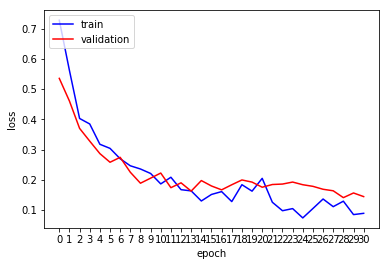

In [51]:
!rm -r {PATH}tmp
# F2 :  0.81 for learning_rate = 1e-4, lr=np.array([learning_rate/100,learning_rate/10,learning_rate]), dropout = [0.25,0.5] 
# F2 :  0.91 for learning_rate = 1e-4, lr=np.array([learning_rate/5,learning_rate/3,learning_rate]), dropout = [0.25,0.5] # good graph
# F2 :  0.93 (acc 94.51 %) for learning_rate = 1e-3, lr=np.array([learning_rate/5,learning_rate/3,learning_rate]), dropout = [0.25,0.5]
# F2 :  0.69 (acc 69.35 %) for learning_rate = 1e-2, lr=np.array([learning_rate/5,learning_rate/3,learning_rate]), dropout = [0.25,0.5] # graphs erratic but goes down
# F2 :  0.93 (acc 91.93 %) for learning_rate = 1e-3, lr=np.array([learning_rate/5,learning_rate/3,learning_rate]), dropout = [0.25,0.5] # graphs erratic at the end but goes down
# F2 :  0.94 (acc 93.54 %) for learning_rate = 1e-3, lr=np.array([learning_rate/5,learning_rate/3,learning_rate]), dropout = 0.5


learning_rate = 1e-3
lr=np.array([learning_rate/5,learning_rate/3,learning_rate])
dropout = 0.5
#[0.25,0.5] 


aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),RandomFlip(),RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2), RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)
learn.unfreeze()
learn.ps=dropout
global_results = collections.OrderedDict([])

training_loop = [
    [123, 300, 1],
    [512, 64, 10],
    [150, 128, 10],
    [123, 300, 10],
]
#    [256, 128, 3],
#    [123, 300, 3],
#    [64, 600, 3],
#    [123, 300, 4],
#    [256, 128, 2],
#    [123, 300, 2],
#    [64, 600, 3],
#    [123, 400, 2]
for bs, sz, epoch in training_loop:
    print("Hyperparameters : Batch size=", bs, " Drop out=", dropout, " Learning rate=", learning_rate, " Cycle=", epoch, " Images sizes=", sz )
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5)
    # On recharge les données avec une taille de batch plus importante pour aller plus vite
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    vals_s2s, ep_vals_s2s = learn.fit(lr, n_cycle=epoch, cycle_len=1, get_ep_vals=True)
    if len(global_results) > 0:
        for k, v in ep_vals_s2s.items(): global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    fichier = arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + "_acc" + str(vals_s2s[1]*100)[:5] + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)
plot_ep_vals(global_results)


[[151   4]                                   
 [ 10 145]]
Precision :  0.9741935483870968
Recall :  0.937888198757764
F1 :  0.9556962025316457
F2 :  0.9449311639549438


array([[151,   4],
       [ 10, 145]])

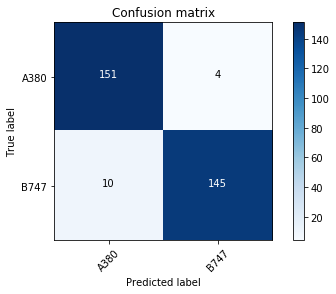

In [52]:
plot_the_confusion_matrix()

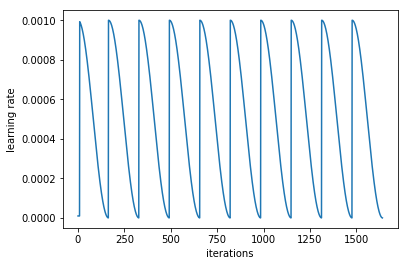

In [53]:
learn.sched.plot_lr()

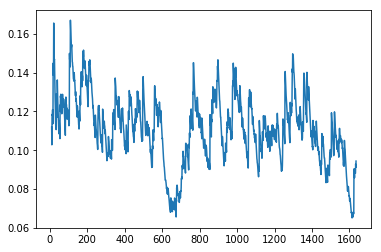

In [54]:
learn.sched.plot_loss()

## Variable cycle length

In [55]:
!rm -r {PATH}tmp

learning_rate = 1e-3
lr=np.array([learning_rate/10,learning_rate/5,learning_rate])
dropout = 0.5
#F2 :  0.96 for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = 0.5
#F2 :  0.92 for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]
#F2 :  0.86 for learning_rate = 1e-2, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = 0.5
#F2 :  0.88 (acc 90    %) for learning_rate = 1e-3, lr=np.array([learning_rate/5,learning_rate/3,learning_rate]), dropout = 0.5 # graph go slowly down, better result at 29 epoch than 44
#F2 :  0.96 (acc 94.83 %) for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = 0.5
#F2 :  0.94 (acc 91.93 %) for learning_rate = 1e-3, lr=np.array([learning_rate/50,learning_rate/10,learning_rate]), dropout = 0.5
#F2 :  0.93 (acc 90.96 %) for learning_rate = 1e-3, lr=np.array([learning_rate/15,learning_rate/6,learning_rate]), dropout = 0.5


aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),RandomFlip(),RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2), RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)
learn.unfreeze()
learn.ps=dropout
global_results = collections.OrderedDict([])

training_loop = [
    [123, 300, 3],
    [512, 64, 4],
    [256, 128, 3],
    [123, 400, 4]
]
for bs, sz, cycle in training_loop:
    print("Hyperparameters : Batch size=", bs, " Drop out=", dropout, " Learning rate=", learning_rate, " Cycle=", cycle, " Images sizes=", sz )
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    vals_s2s, ep_vals_s2s = learn.fit(lr, cycle, cycle_len=1, cycle_mult=2, get_ep_vals=True)
    if len(global_results) > 0:
        for k, v in ep_vals_s2s.items(): global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    fichier = arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + "_acc" + str(vals_s2s[1]*100)[:5] + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)


Hyperparameters : Batch size= 123  Drop out= 0.5  Learning rate= 0.001  Cycle= 3  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                    
    0      0.700186   0.577538   0.687097  
    1      0.562192   0.409464   0.790323                    
    2      0.419957   0.393151   0.822581                    
    3      0.365745   0.455026   0.774194                    
    4      0.25464    0.318196   0.851613                    
    5      0.281509   0.320466   0.845161                    
    6      0.274566   0.294714   0.864516                    
After  7  epochs, the accuracy is  86.45 %
Saving to  resnext50_7_300_acc86.45_weights
Hyperparameters : Batch size= 512  Drop out= 0.5  Learning rate= 0.001  Cycle= 4  Images sizes= 64


epoch      trn_loss   val_loss   accuracy                    
    0      0.239704   0.296294   0.870968  
    1      0.269026   0.298718   0.870968                    
    2      0.219863   0.299784   0.86129                     
    3      0.243894   0.261441   0.867742                    
    4      0.19791    0.243984   0.896774                    
    5      0.169104   0.28149    0.883871                    
    6      0.1792     0.297569   0.874194                    
    7      0.148695   0.260469   0.909677                    
    8      0.162152   0.235755   0.9                         
    9      0.144522   0.231038   0.893548                    
    10     0.159701   0.253781   0.890323                    
    11     0.134844   0.236193   0.906452                    
    12     0.130435   0.23227    0.906452                     
    13     0.153408   0.305584   0.870968                    
    14     0.143293   0.251901   0.887097                    
After  22  epochs, the ac

epoch      trn_loss   val_loss   accuracy                    
    0      0.128703   0.250245   0.906452  
    1      0.106776   0.390153   0.854839                     
    2      0.143865   0.36169    0.880645                     
    3      0.164769   0.443753   0.822581                    
    4      0.13507    0.221722   0.922581                    
    5      0.097311   0.279237   0.909677                     
    6      0.111812   0.261395   0.903226                     
After  29  epochs, the accuracy is  90.32 %
Saving to  resnext50_29_128_acc90.32_weights
Hyperparameters : Batch size= 123  Drop out= 0.5  Learning rate= 0.001  Cycle= 4  Images sizes= 400


epoch      trn_loss   val_loss   accuracy                     
    0      0.118278   0.212331   0.922581  
    1      0.104432   0.225067   0.903226                     
    2      0.10796    0.230601   0.906452                     
    3      0.12446    0.226216   0.903226                     
    4      0.144594   0.221832   0.919355                     
    5      0.084665   0.202154   0.906452                     
    6      0.110372   0.22647    0.903226                     
    7      0.118936   0.19414    0.922581                    
    8      0.084237   0.198266   0.909677                     
    9      0.088693   0.204576   0.922581                     
    10     0.167505   0.20422    0.916129                    
    11     0.113607   0.229606   0.9                          
    12     0.085571   0.204248   0.919355                     
    13     0.09335    0.234862   0.903226                     
    14     0.065699   0.202691   0.909677                     
After  44  ep

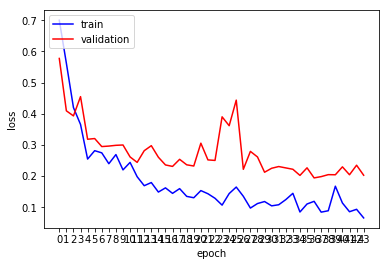

In [56]:
#plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plot_ep_vals(global_results)


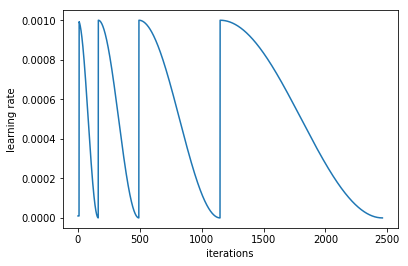

In [57]:
learn.sched.plot_lr()

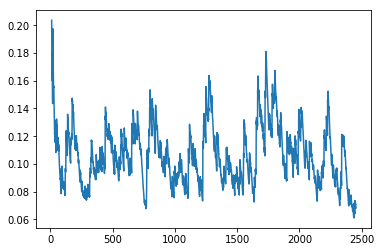

In [58]:
learn.sched.plot_loss()

[[140  15]                                   
 [  9 146]]
Precision :  0.9032258064516129
Recall :  0.9395973154362416
F1 :  0.9210526315789472
F2 :  0.9320905459387483


array([[140,  15],
       [  9, 146]])

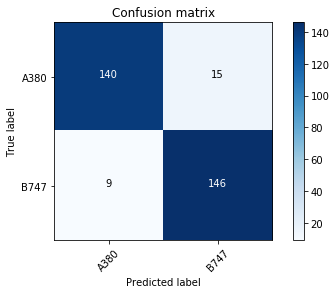

In [59]:
plot_the_confusion_matrix()

# More epochs and SWA

In [112]:
!rm -r {PATH}tmp
# resnext50 results :
#F2 :  0.95 (acc 91.29%) for learning_rate = 1e-3, lr=np.array([learning_rate/5,learning_rate/3,learning_rate]), dropout = [0.25,0.5] # 
#F2 :  0.93 (acc 91.93%) with SWA=3 for learning_rate = 1e-2, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]XXX SWA = 3
#F2 :  0.95 (acc 91.29%) with SWA=3 for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]
# and training_loop = [
#     [512, 64, 3, lr],
#     [256, 128, 4, lr],
#     [123, 300, 6, lr/2],
#     [64, 600, 4, lr/4]
# ]
# F2 :  0.96 (acc 95.48%), w/o SWA , learning_rate = 1e-3, [learning_rate/10,learning_rate/5,learning_rate], dropout = [0.25,0.5], 
# training_loop = [
#     [512, 64, 4],
#     [256, 128, 3],
#     [123, 300, 3],
#     [64, 600, 3],
#     [123, 300, 6],
#     [256, 128, 2],
#     [123, 300, 2],
#     [64, 600, 3],
#     [123, 400, 2]
# ]


# F2 :  0.959 (acc 95.80 %) with SWA=3 for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]
# training_loop = [
#     [512, 64, 4, lr*2],
#     [256, 128, 3, lr],
#     [123, 300, 3, lr],
#     [64, 600, 3, lr],
#     [123, 300, 6, lr/2],
#     [64, 600, 3, lr/5],
#     [123, 400, 4, lr/5]
# ] => 121  epochs


# F2 :  0.97 96.12 % w/o SWA for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]
# training_loop = [
#     [512, 64, 4, lr*2],
#     [256, 128, 3, lr],
#     [123, 300, 3, lr],
#     [64, 600, 3, lr],
#     [123, 300, 6, lr/2],
#     [64, 600, 3, lr/5],
#     [123, 400, 4, lr/5]
# ] => 121  epochs


# F2 :  0.92 (acc 90.32 %) for w/o SWA for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]
# training_loop = [
#     [512, 64, 4, lr*2],
#     [256, 128, 3, lr],
#     [123, 300, 3, lr],
#     [64, 600, 3, lr],
#     [123, 300, 6, lr/2],
#     [64, 600, 3, lr/5],
#     [123, 400, 6, lr/5]
# ]
# After  169  epochs, the accuracy is  90.32 %


# F2 :  0.91 (acc 92.25 %) learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]
# training_loop = [
#     [512, 64, 4, lr*2],
#     [256, 128, 3, lr],
#     [123, 300, 6, lr/2],
#     [123, 400, 4, lr/5]
# ]
# After  100  epochs, the accuracy is  92.25 %


# F2 :  0.96 learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]
# training_loop = [
#     [512, 64, 4, lr*2],
#     [256, 128, 3, lr],
#     [123, 300, 6, lr*2]
# ]
# After  85  epochs, the accuracy is  95.48 %


#F2 :  0.95 (acc 95.48 %) for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]
#     [512, 64, 4, lr*2],
#     [256, 128, 6, lr],
#     [123, 300, 7, lr*2]
#After  205  epochs, the accuracy is  95.48 %

# resnet34 result :
    # F2 :  0.86 for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]
    
    
learning_rate = 1e-3
lr=np.array([learning_rate/10,learning_rate/5,learning_rate])
dropout = [0.25,0.5]
#arch=resnet34
aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),RandomFlip(),RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2), RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, 299, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)
learn.unfreeze()
learn.ps=dropout
global_results = collections.OrderedDict([])

training_loop = [
    [512, 64, 4, lr*2],
    [256, 128, 6, lr],
    [123, 300, 8, lr*2]
    #[123, 400, 4, lr*5]
]


for bs, sz, cycle, lr in training_loop:
    print("Hyperparameters for ", arch.__name__, " : Batch size=", bs, " Drop out=", dropout, " Learning rate=", lr, " Cycle=", cycle, " Images sizes=", sz )
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    vals_s2s, ep_vals_s2s = learn.fit(lr, cycle, cycle_len=1, cycle_mult=2, get_ep_vals=True, best_save_name=arch.__name__ + "_bestmodel") # , use_swa=True, swa_start=3
    if len(global_results) > 0:
        for k, v in ep_vals_s2s.items(): global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    fichier = arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + "_acc" + str(vals_s2s[1]*100)[:5] + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)



Hyperparameters for  resnext50  : Batch size= 512  Drop out= [0.25, 0.5]  Learning rate= [0.0002 0.0004 0.002 ]  Cycle= 4  Images sizes= 64


epoch      trn_loss   val_loss   accuracy                    
    0      0.668101   0.745087   0.625806  
    1      0.504763   0.559613   0.722581                    
    2      0.388533   0.415094   0.809677                    
    3      0.375227   0.4264     0.806452                    
    4      0.319955   0.355259   0.832258                    
    5      0.242863   0.294931   0.864516                    
    6      0.183326   0.363873   0.822581                    
    7      0.238515   0.251485   0.893548                    
    8      0.261709   0.319268   0.874194                    
    9      0.189144   0.228105   0.903226                    
    10     0.155781   0.237907   0.903226                    
    11     0.123136   0.220298   0.887097                    
    12     0.148189   0.247497   0.877419                     
    13     0.097458   0.214993   0.880645                     
    14     0.109684   0.235174   0.887097                     
After  15  epochs, the 

epoch      trn_loss   val_loss   accuracy                     
    0      0.121204   0.20796    0.912903  
    1      0.097261   0.236261   0.922581                     
    2      0.114108   0.208619   0.922581                     
    3      0.127816   0.253359   0.9                         
    4      0.110076   0.197449   0.932258                    
    5      0.101392   0.203306   0.909677                     
    6      0.073841   0.20762    0.909677                     
    7      0.100718   0.287149   0.870968                     
    8      0.118058   0.251679   0.896774                    
    9      0.091009   0.191218   0.922581                     
    10     0.050231   0.283898   0.874194                     
    11     0.09002    0.242294   0.877419                     
    12     0.072748   0.192655   0.925806                     
    13     0.080899   0.223381   0.903226                     
    14     0.081371   0.186041   0.925806                     
    15     0.0

epoch      trn_loss   val_loss   accuracy                     
    0      0.057949   0.239871   0.922581  
    1      0.054245   0.217691   0.912903                     
    2      0.084102   0.202281   0.919355                     
    3      0.066907   0.17208    0.919355                     
    4      0.069137   0.189915   0.922581                     
    5      0.105622   0.191347   0.919355                     
    6      0.047889   0.168153   0.919355                     
    7      0.0801     0.219465   0.909677                     
    8      0.12661    0.207106   0.925806                     
    9      0.110207   0.167897   0.935484                     
    10     0.076552   0.16046    0.935484                     
    11     0.073721   0.172411   0.945161                     
    12     0.077314   0.1424     0.945161                     
    13     0.119571   0.1654     0.941935                     
    14     0.055899   0.133387   0.945161                     
    15     

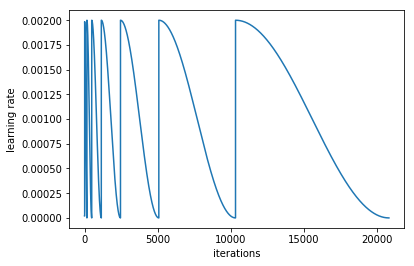

In [113]:
learn.sched.plot_lr()

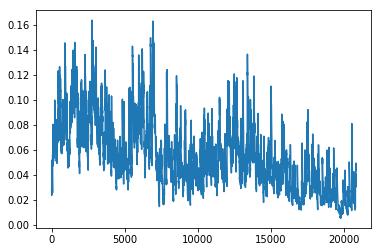

In [114]:
learn.sched.plot_loss()

<Figure size 1120x640 with 0 Axes>

[[149   6]                                   
 [  7 148]]
Precision :  0.9612903225806452
Recall :  0.9551282051282052
F1 :  0.9581993569131833
F2 :  0.9563543003851093


array([[149,   6],
       [  7, 148]])

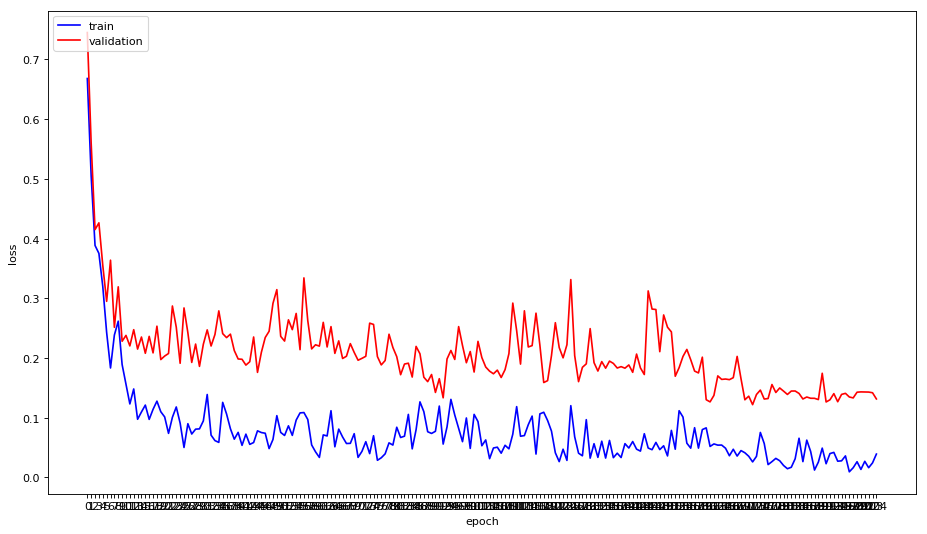

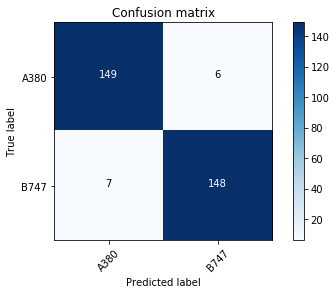

In [115]:

plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plot_ep_vals(global_results)
plot_the_confusion_matrix()

In [146]:
#loadmodel=False
loadmodel=True
if loadmodel==True:
    aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),RandomFlip(),RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2), RandomStretch(max_stretch=0.2)]
    tfms = tfms_from_model(arch, 299, aug_tfms=aug_tfms, max_zoom=1.1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
    learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)
    learn.load("resnext50_141_300_acc98.06_weights")
    #learn.load(arch.__name__ + "_bestmodel")
    #learn.freeze()
    #learn.TTA()
    #vals_s2s, global_results = learn.fit(0.00001, n_cycle=1, get_ep_vals=True)
    #plot_ep_vals(global_results)
    print("Model chargé")

Model chargé


# Prediction et visualisation

[[152   3]                                   
 [  3 152]]
Precision :  0.9806451612903225
Recall :  0.9806451612903225
F1 :  0.9806451612903225
F2 :  0.9806451612903224


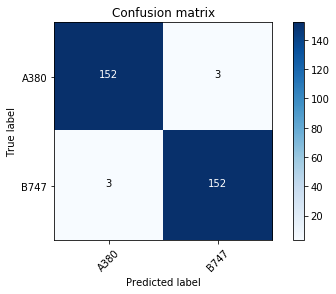

In [147]:
cm = plot_the_confusion_matrix()

In [138]:
#?plot_confusion_matrix

## Precision and Recall
Précision et rappel en français : https://fr.wikipedia.org/wiki/Pr%C3%A9cision_et_rappel
_La précision est le nombre de documents pertinents retrouvés rapporté au nombre de documents total proposé par le moteur de recherche pour une requête donnée. _ Autrement dit quelle proportion d'identifications positives était effectivement correcte ?

_Le rappel est défini par le nombre de documents pertinents retrouvés au regard du nombre de documents pertinents que possède la base de données._ Autrement dit quelle proportion de résultats positifs réels a été identifiée correctement ?

In [148]:
# precission = VP / (VP + FP)
precision = cm[0][0]/(cm[0][1]+cm[0][0]);
print("Precision : ", precision)
# recall =  = VP / (VP + FN)
recall = cm[0][0]/(cm[1][0]+cm[0][0]);
print("recall : ", recall)
F1 = 2 * ((precision*recall)/(precision + recall))
print("F1 : ", F1)
F2 = 5 * ((precision*recall)/(4*precision + recall))
print("F2 : ", F2)

Precision :  0.9806451612903225
recall :  0.9806451612903225
F1 :  0.9806451612903225
F2 :  0.9806451612903224


In [149]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape  # = (nombre de prediction , nombre de classe)
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

from math import ceil
nb_images = 6

# Récupère aléatoirement des prédictions
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), nb_images), replace=False)

# Récupère les prédictions correctes
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

# Affiche les images
def plots(ims, figsize=(20,10), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=12)
        plt.imshow(ims[i])

# Charge l'image
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

# Affiche des images avec un titre
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [(str(probs[x]) + "\n" + str(data.val_ds.fnames[x][10:][:20])) for x in idxs]
    print(title)
    nb_lignes = ceil(len(idxs) / 3)
    return plots(imgs, rows=nb_lignes, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

# Recupère les prédiction triées
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:nb_images]] # Les nb_images premiers éléments

# Recupère les prédictions les plus justes
def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

['A380', 'B747']

(310, 2)

Most incorrect A380


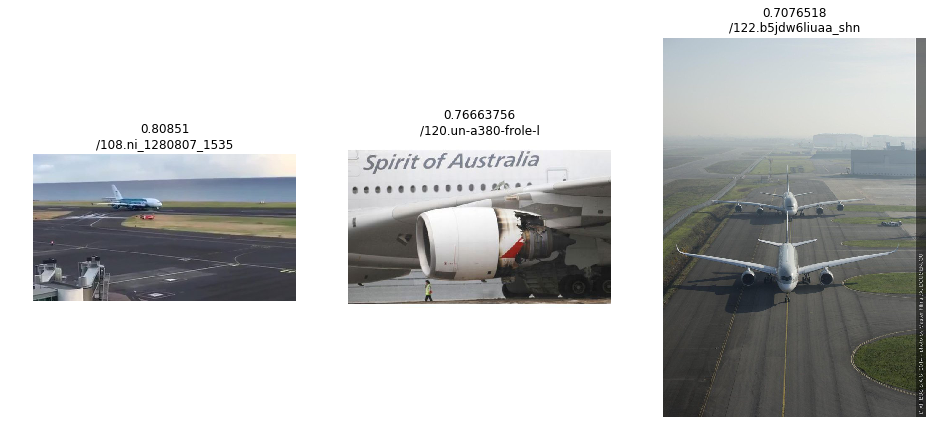

In [150]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect " + data.classes[0])

Most incorrect B747


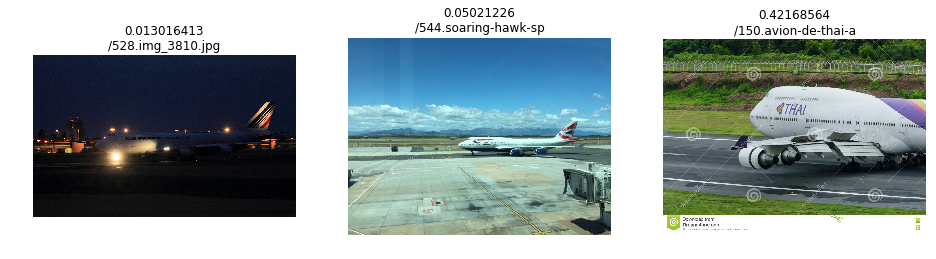

In [151]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect " + data.classes[1])

Most uncertain predictions


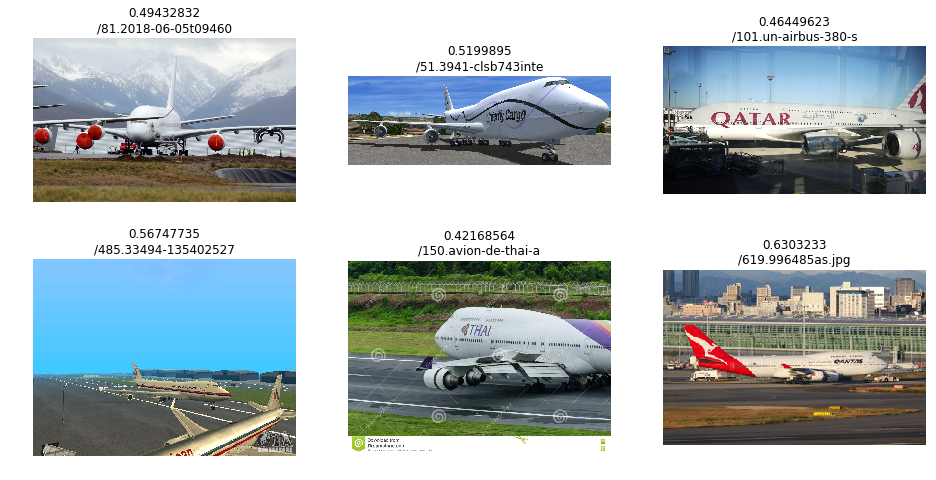

In [152]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:nb_images]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

Most correct B747


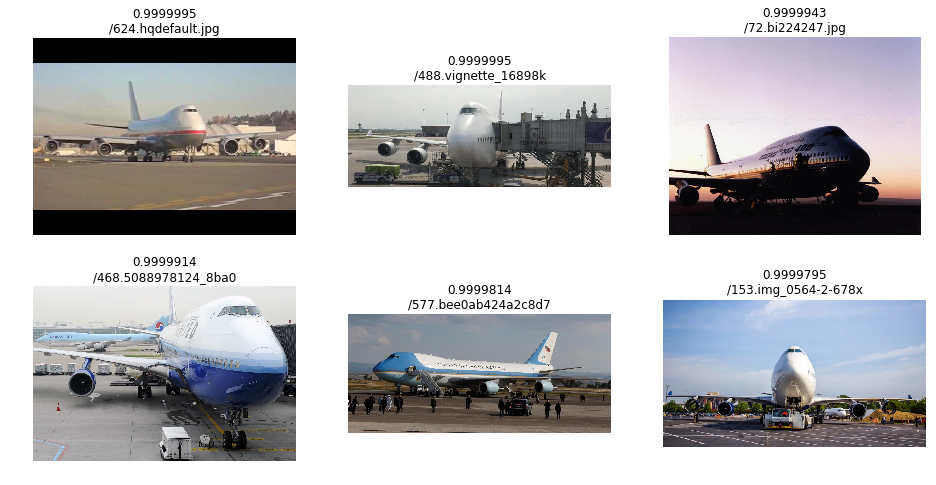

In [153]:
plot_val_with_title(most_by_correct(1, True), "Most correct " + data.classes[1])

Most correct A380


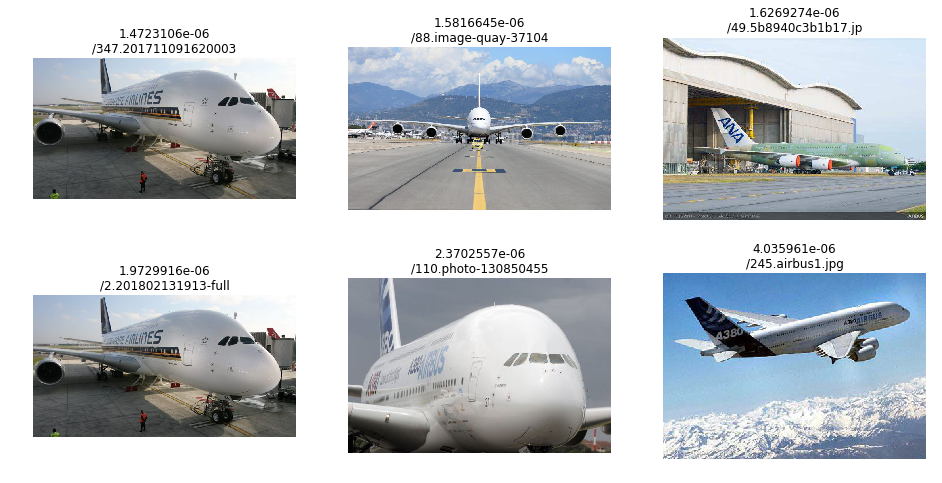

In [154]:
plot_val_with_title(most_by_correct(0, True), "Most correct " + data.classes[0])
# 1. A few correct labels at random
#plot_val_with_title(rand_by_correct(True), "Correctly classified")
# 2. A few incorrect labels at random
#plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

C'est bon, les plus petites font plus de 200 pixels.
On note que la majorité on une taille importante, il sera bon de faire des entrainement du modèle avec des tailles supérieures.

_"How many images should we use as a validation set? [01:26:28] Using 20% is fine unless the dataset is small — then 20% is not enough. If you train the same model multiple times and you are getting very different validation set results, then your validation set is too small. If the validation set is smaller than a thousand, it is hard to interpret how well you are doing. If you care about the third decimal place of accuracy and you only have a thousand things in your validation set, a single image changes the accuracy. If you care about the difference between 0.01 and 0.02, you want that to represent 10 or 20 rows. Normally 20% seems to work fine."_
=> Nous avons environs 100 images de validation par classes, ça devrait donc aller.

Faisons un test d'entrainement avec une petite taille de batch pour estimer la valeur du learning rate.